In [1]:
import kala
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

In [2]:
def helper_diagonal_sbm(num_nodes, p_off, p_diag=1.0, seed=0, return_pos=True):
    n = num_nodes // 2
    sizes = [n, n + num_nodes % 2]

    p_mat = [
        [p_diag, p_off],
        [p_off, p_diag],
    ]

    g = nx.stochastic_block_model(sizes, p_mat, seed=seed)
    # g.graph["partition"]

    if return_pos:
        pos = nx.spring_layout(g, seed=seed)
        out = (g, pos)
    else:
        out = g

    return out


def helper_two_group_assigment(num_nodes, threshold=0.5, seed=0):
    rng = np.random.default_rng(seed)

    n = num_nodes // 2
    sizes = [n, n + num_nodes % 2]
    block1 = rng.random(size=n) < threshold
    block2 = rng.random(size=n + num_nodes % 2) < 1 - threshold

    return np.hstack((block1, block2))


def _get_broken_down_wealth(game, is_saver):
    return (
        game.get_total_wealth(),
        game.get_total_wealth(filt=is_saver),
        game.get_total_wealth(filt=~is_saver),
    )


def helper_run_simulation(game, is_saver, num_steps):
    game.reset_agents()

    data = [_get_broken_down_wealth(game, is_saver)]

    for _ in range(num_steps):
        game.play_round()
        data.append(_get_broken_down_wealth(game, is_saver))

    return pd.DataFrame(data, columns=["total", "saver", "non-saver"])

In [3]:
num_players = 40

g, pos = helper_diagonal_sbm(num_players, p_off=0.1)

kwargs = {
    "differential_efficient": 0.15,
    "differential_inefficient": 0.1,
}

deterministic_strategy = kala.CooperationStrategy(stochastic=False, **kwargs)
stochastic_strategy = kala.CooperationStrategy(stochastic=True, rng=0, **kwargs)

## Validation: all the players are non-savers

When all the players are non-savers, the wealth should increase at a constant rate of `num_players` units per time even for the case of a stochastic strategy (stochastic payoffs).

In [4]:
is_saver = np.zeros(num_players, dtype=bool)

print(f"Savers:\t\t{np.sum(is_saver)}")
print(f"Non-savers:\t{np.sum(~is_saver)}")

Savers:		0
Non-savers:	40


In [5]:
players = [kala.InvestorAgent(is_saver=s) for s in is_saver]
G = kala.SimpleGraph(g, nodes=players)

game = kala.DiscreteTwoByTwoGame(G, stochastic_strategy)

results_all_non_savers = helper_run_simulation(game, is_saver, num_steps=50)

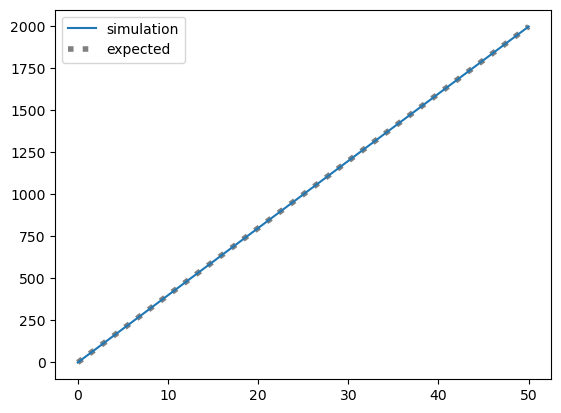

In [6]:
xs = np.array([0, 50])
ys = xs * num_players

fig, ax = plt.subplots()
results_all_non_savers["total"].plot(ax=ax, label="simulation")
ax.plot(
    xs, ys, color="0.5", linestyle="dotted", linewidth=4, zorder=-1, label="expected"
)
ax.legend()

## Homogenous mixing

If there is the same rate of savers in both clusters, then savers and non-savers alike are connected in the same way and we are in the case of homogeneous mixing.

In [7]:
saver_thresh = 0.5

is_saver = helper_two_group_assigment(num_players, threshold=saver_thresh)

print(f"Savers:\t\t{np.sum(is_saver)}")
print(f"Non-savers:\t{np.sum(~is_saver)}")

Savers:		16
Non-savers:	24


In [8]:
players = [kala.InvestorAgent(is_saver=s) for s in is_saver]
G = kala.SimpleGraph(g, nodes=players)

game = kala.DiscreteTwoByTwoGame(G, stochastic_strategy)

results_05 = helper_run_simulation(game, is_saver, num_steps=50)

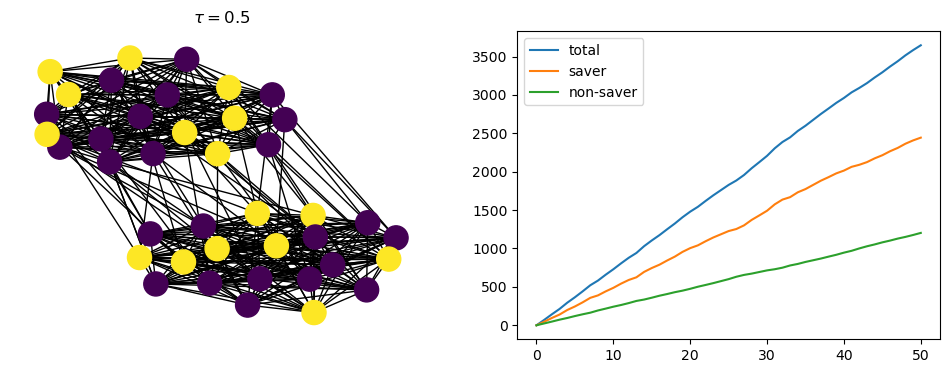

In [9]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

ax = axs[0]
nx.draw(g, node_color=is_saver, pos=pos, ax=ax)
ax.set_title(rf"$\tau = {saver_thresh}$")

ax = axs[1]
results_05.plot(ax=ax);

## Inhomogeneuous mixing

Each cluster has savers/non-savers at a higher rate so that the mixing between different types of agents is poor.

In [10]:
saver_thresh = 0.9

is_saver = helper_two_group_assigment(num_players, threshold=saver_thresh)

print(f"Savers:\t\t{np.sum(is_saver)}")
print(f"Non-savers:\t{np.sum(~is_saver)}")

Savers:		19
Non-savers:	21


In [11]:
players = [kala.InvestorAgent(is_saver=s) for s in is_saver]
G = kala.SimpleGraph(g, nodes=players)

game = kala.DiscreteTwoByTwoGame(G, stochastic_strategy)

results_09 = helper_run_simulation(game, is_saver, num_steps=50)

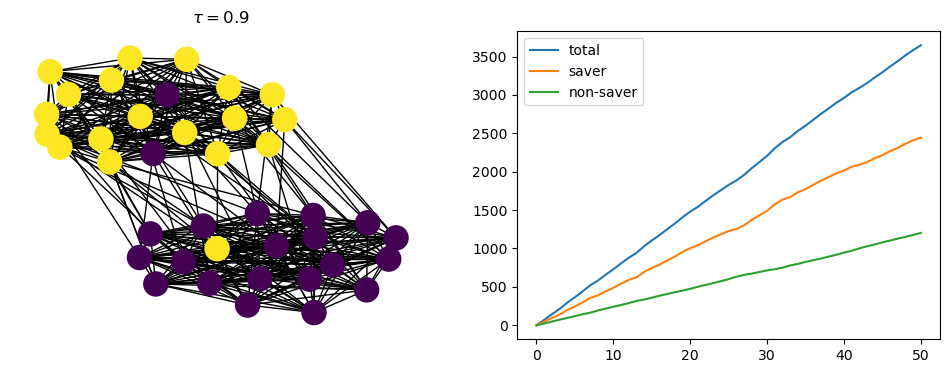

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

ax = axs[0]
nx.draw(g, node_color=is_saver, pos=pos, ax=ax)
ax.set_title(rf"$\tau = {saver_thresh}$")

ax = axs[1]
results_05.plot(ax=ax);

## Side-by-side comparison

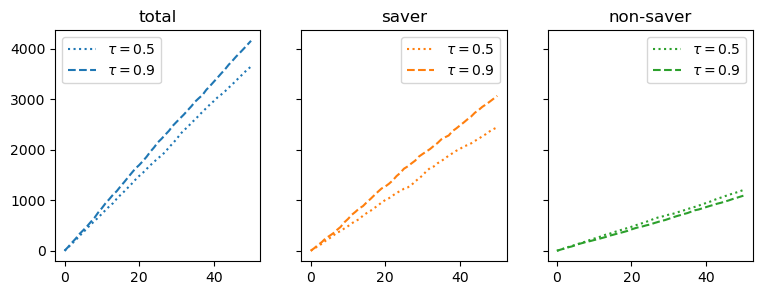

In [13]:
fig, axs = plt.subplots(figsize=(9, 3), ncols=3, sharey=True)

for ax, col, c in zip(axs, ["total", "saver", "non-saver"], ["C0", "C1", "C2"]):
    results_05[col].plot(color=c, linestyle="dotted", ax=ax, label=r"$\tau = 0.5$")
    results_09[col].plot(color=c, linestyle="dashed", ax=ax, label=r"$\tau = 0.9$")
    ax.set_title(col)
    ax.legend()